# The Acceleration Principle and the Nature of Business Cycles
## A Companion Notebook to Chow (1968)

**Gregory C. Chow**, *The Quarterly Journal of Economics*, Vol. 82, No. 3 (Aug., 1968), pp. 403–418.

📄 **Paper**: [Read the full MyST article](https://mmcky.github.io/paper-chow-1968/paper) | [Original PDF](../original/Chow-QJE_1968_AccelerationPrincipleNature-1968.pdf)

---

### Overview

This notebook explores the key ideas from Chow (1968) through Python-based demonstrations. The paper asks a deceptively simple question:

> **Is the acceleration principle necessary for generating business cycles?**

Chow shows that:
1. In a **deterministic** system of demand equations (without acceleration), all characteristic roots are real and positive — **no oscillations are possible**.
2. When **acceleration** is introduced, complex roots can appear, producing oscillations.
3. In a **stochastic** system, random shocks can generate cycles **even without complex roots** — the acceleration principle is no longer *necessary*.
4. The relationship between complex roots and spectral peaks is subtle: complex roots are **neither necessary nor sufficient** for distinct cycles in general.

### Outline

1. [Setup](#setup)
2. [The Acceleration Principle](#acceleration-principle)
3. [Nonstochastic System: Eigenvalue Analysis](#nonstochastic-eigenvalues)
4. [Adding Acceleration: Complex Roots Emerge](#acceleration-complex-roots)
5. [Stochastic Systems and Autocovariances](#stochastic-autocovariances)
6. [Spectral Densities and Business Cycles](#spectral-densities)
7. [The Hansen–Samuelson Model](#hansen-samuelson)
8. [Chow's Surprising Result: Cycles Without Complex Roots](#chow-surprise)
9. [Interactive Exploration](#interactive)

<a id="setup"></a>

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, signal

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
})

np.random.seed(42)
print("Setup complete.")

Setup complete.


<a id="acceleration-principle"></a>

## 2. The Acceleration Principle

Chow derives the acceleration principle from a **stock adjustment equation**. Suppose the
desired stock $s_i$ of a durable good depends on national income $Y$ and adjusts partially:

$$s_{it} = a_i Y_t + b_i s_{i,t-1}$$

Taking **first differences** gives **net investment** $y^n_{it} = \Delta s_{it}$:

$$y^n_{it} = a_i \Delta Y_t + b_i y^n_{i,t-1}$$

This is the **acceleration principle**: net investment depends on the *change* in income ($\Delta Y_t$),
not the level. The key implication is that even moderate changes in income growth can
produce large swings in investment.

Let's visualize this with a simple simulation.

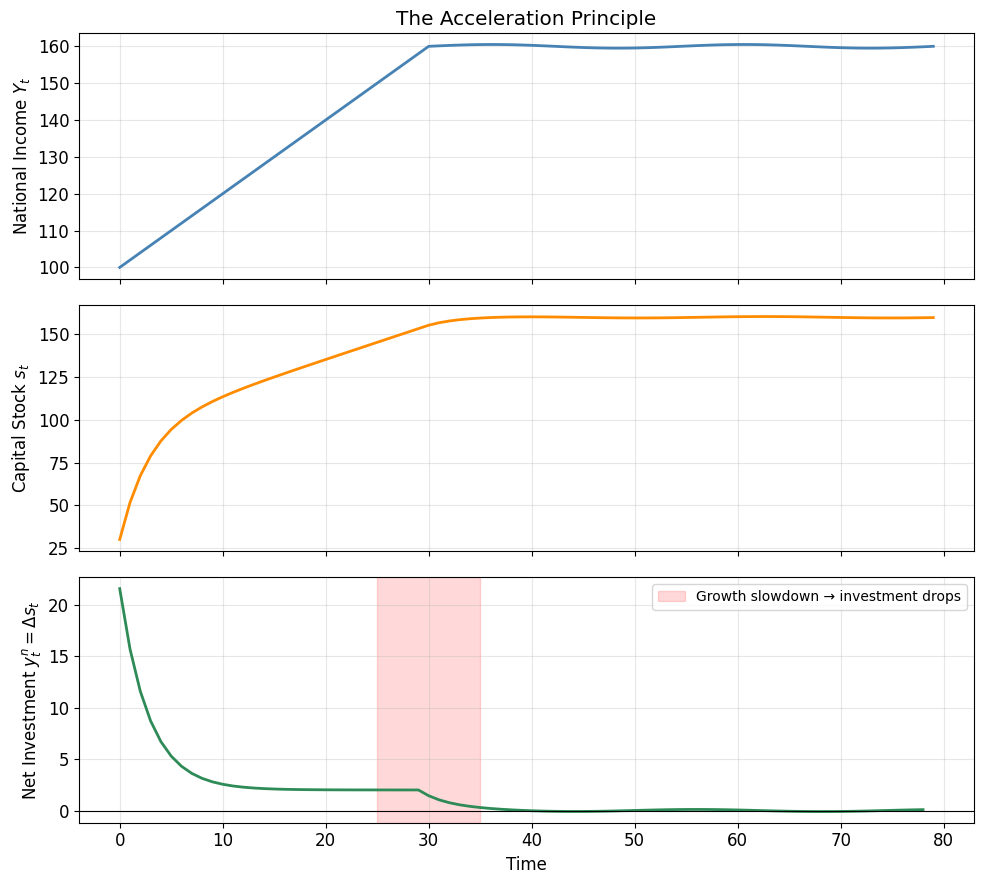

Key insight: When income growth merely SLOWS (not declines),
net investment can drop sharply — the acceleration effect.


In [2]:
# --- The Acceleration Principle: Stock vs. Flow ---

T = 80
a_i, b_i = 0.3, 0.7

# National income: grows then levels off
Y = np.concatenate([
    100 + 2 * np.arange(30),
    160 + 0.5 * np.sin(np.linspace(0, 4*np.pi, 50))
])

# Stock adjustment: s_t = a * Y_t + b * s_{t-1}
s = np.zeros(T)
s[0] = a_i * Y[0]
for t in range(1, T):
    s[t] = a_i * Y[t] + b_i * s[t - 1]

# Net investment = Δs (the acceleration relation)
net_inv = np.diff(s)

fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

axes[0].plot(Y, color='steelblue')
axes[0].set_ylabel('National Income $Y_t$')
axes[0].set_title('The Acceleration Principle')

axes[1].plot(s, color='darkorange')
axes[1].set_ylabel('Capital Stock $s_t$')

axes[2].plot(net_inv, color='seagreen')
axes[2].axhline(0, color='black', lw=0.8)
axes[2].set_ylabel('Net Investment $y^n_t = \\Delta s_t$')
axes[2].set_xlabel('Time')

# Highlight: income growth slows → investment drops
axes[2].axvspan(25, 35, alpha=0.15, color='red',
                label='Growth slowdown → investment drops')
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Key insight: When income growth merely SLOWS (not declines),")
print("net investment can drop sharply — the acceleration effect.")

<a id="nonstochastic-eigenvalues"></a>

## 3. Nonstochastic System: No Oscillations Without Acceleration

Chow considers a system of $p$ demand equations for components $y_i$ of national product
$Y = \sum y_i$, each obeying a simple distributed lag:

$$y_{it} = a_i Y_t + b_i y_{i,t-1}$$

Written in matrix form as $Gy_t = D_b y_{t-1}$ where $A = G^{-1} D_b$, Chow proves two
key results:

1. **All eigenvalues of $A$ are real** (follows because $D_b^{-1}G$ is a product of a positive definite and a symmetric matrix).
2. **All eigenvalues are positive** if and only if $\sum a_i < 1$ (i.e., total marginal propensities less than unity).

**Consequence**: With only real, positive roots, the system $y_t = A^t y_0$ cannot exhibit
prolonged oscillations. Let's verify this numerically.

In [3]:
def build_demand_system(a_vec, b_vec):
    """
    Build the system matrices for Chow's demand equation system.

    Given marginal propensities a = (a_1, ..., a_p) and lag coefficients
    b = (b_1, ..., b_p), constructs:
      G y_t = D_b y_{t-1}   =>   A = G^{-1} D_b

    Returns: A, G, D_b, eigenvalues
    """
    p = len(a_vec)
    a_vec = np.array(a_vec, dtype=float)
    b_vec = np.array(b_vec, dtype=float)

    # G = I - F, where row i of F is (a_i, a_i, ..., a_i)
    F = np.outer(a_vec, np.ones(p))
    G = np.eye(p) - F
    D_b = np.diag(b_vec)

    A = linalg.solve(G, D_b)  # G^{-1} D_b
    eigenvalues = linalg.eigvals(A)
    return A, G, D_b, eigenvalues


# --- Example: 4-sector economy without acceleration ---
a = [0.15, 0.20, 0.10, 0.12]  # marginal propensities (sum = 0.57 < 1)
b = [0.70, 0.50, 0.80, 0.60]  # lag coefficients

A, G, D_b, eigs = build_demand_system(a, b)

print("Marginal propensities a_i:", a)
print(f"Sum of a_i = {sum(a):.2f} < 1 ✓")
print(f"\nEigenvalues of A = G⁻¹ D_b:")
for i, ev in enumerate(eigs):
    print(f"  λ_{i+1} = {ev.real:+.6f}" +
          (f" {ev.imag:+.6f}i" if abs(ev.imag) > 1e-10 else " (real)"))

print(f"\nAll real? {all(abs(ev.imag) < 1e-10 for ev in eigs)}")
print(f"All positive? {all(ev.real > 0 for ev in eigs)}")

Marginal propensities a_i: [0.15, 0.2, 0.1, 0.12]
Sum of a_i = 0.57 < 1 ✓

Eigenvalues of A = G⁻¹ D_b:
  λ_1 = +1.491443 (real)
  λ_2 = +0.761820 (real)
  λ_3 = +0.638023 (real)
  λ_4 = +0.538946 (real)

All real? True
All positive? True


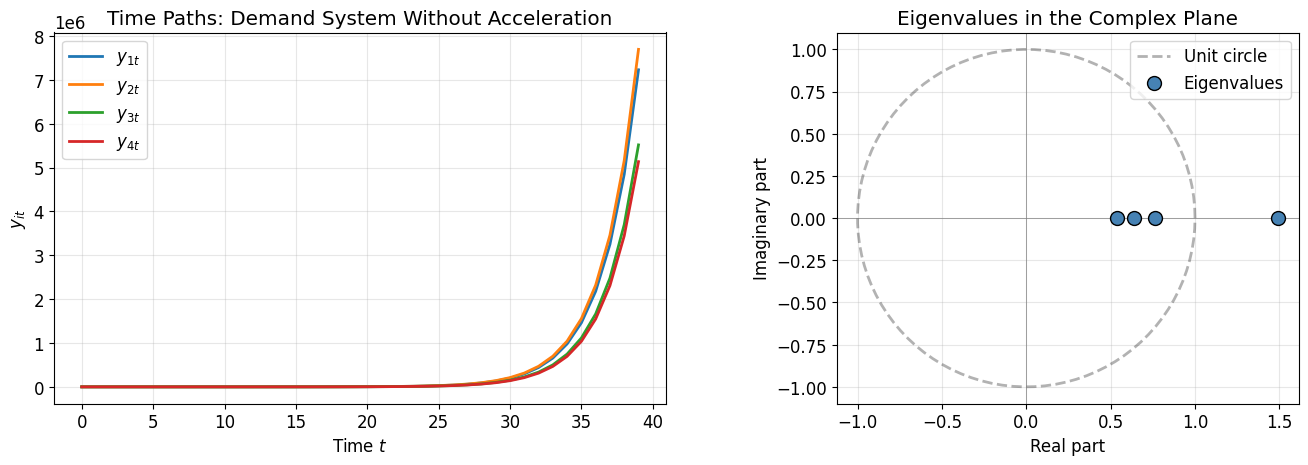

All eigenvalues lie on the positive real axis → no oscillations.


In [4]:
# --- Simulate the nonstochastic system: monotone convergence, no oscillations ---

T = 40
y0 = np.array([1.0, 0.5, 1.5, 0.8])

# y_t = A^t y_0
trajectory = np.zeros((T, len(y0)))
trajectory[0] = y0
for t in range(1, T):
    trajectory[t] = A @ trajectory[t - 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time paths
for i in range(len(y0)):
    axes[0].plot(trajectory[:, i], label=f'$y_{{{i+1}t}}$')
axes[0].set_xlabel('Time $t$')
axes[0].set_ylabel('$y_{it}$')
axes[0].set_title('Time Paths: Demand System Without Acceleration')
axes[0].legend()

# Eigenvalues in the complex plane
theta = np.linspace(0, 2*np.pi, 100)
axes[1].plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3, label='Unit circle')
axes[1].scatter(eigs.real, eigs.imag, s=100, c='steelblue', zorder=5,
                edgecolors='black', label='Eigenvalues')
axes[1].axhline(0, color='grey', lw=0.5)
axes[1].axvline(0, color='grey', lw=0.5)
axes[1].set_xlabel('Real part')
axes[1].set_ylabel('Imaginary part')
axes[1].set_title('Eigenvalues in the Complex Plane')
axes[1].set_aspect('equal')
axes[1].legend()

plt.tight_layout()
plt.show()

print("All eigenvalues lie on the positive real axis → no oscillations.")

<a id="acceleration-complex-roots"></a>

## 4. Adding Acceleration: Complex Roots Emerge

Chow notes that replacing even **one** demand equation with an acceleration equation can
introduce complex eigenvalues, producing oscillatory dynamics.

The acceleration equation for gross investment is:

$$y_{it} = a_i [Y_t - (1-\delta_i) Y_{t-1}] + b_i y_{i,t-1}$$

This creates a second-order system (dependence on both $Y_t$ and $Y_{t-1}$), which when
written as a first-order augmented system, can have complex roots.

Let's demonstrate by replacing the first demand equation with an acceleration equation
and comparing the eigenvalue structure.

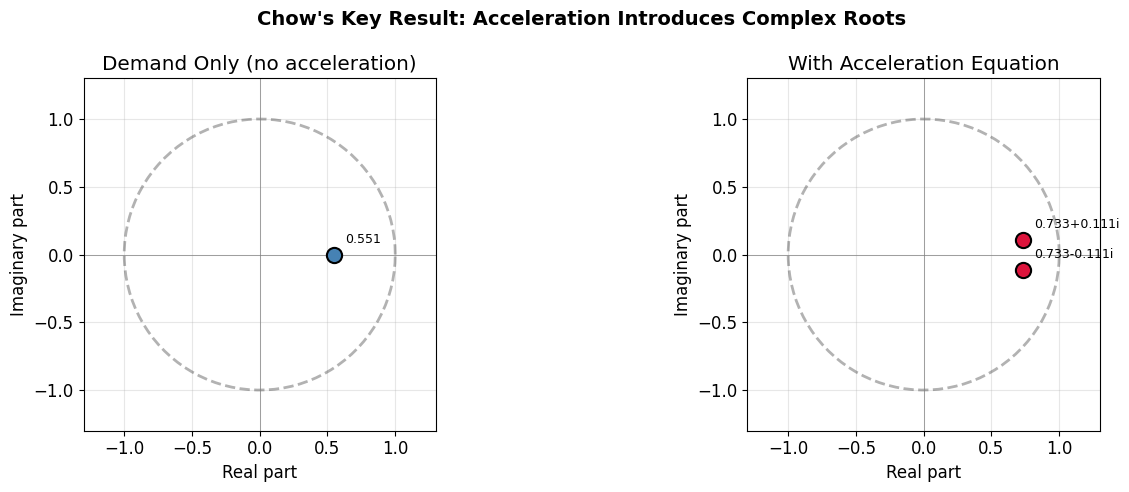

Demand only eigenvalues:    ['1.8160', '0.5507']
With acceleration eigenvalues: ['0.7333+0.1106j', '0.7333-0.1106j']
Complex roots with acceleration? True


In [5]:
# --- Two-variable system: demand only vs. demand + acceleration ---

def build_system_with_acceleration(a1, b1, a2, b2, delta1):
    """
    Build a 3-variable augmented system where:
      - Variable 1 follows an acceleration equation (gross investment)
      - Variable 2 follows a standard demand equation
      - Variable 3 = Y_{t-1} (augmented state for the second-order terms)

    The acceleration eq: y_{1t} = a1 [Y_t - (1-δ₁)Y_{t-1}] + b1 y_{1,t-1}
    The demand eq:       y_{2t} = a2 Y_t + b2 y_{2,t-1}
    Y_t = y_{1t} + y_{2t}
    """
    # This creates a coupled system. Write it as:
    # (1 - a1) y_{1t} - a1 y_{2t} = -a1(1-δ₁)(y_{1,t-1} + y_{2,t-1}) + b1 y_{1,t-1}
    # -a2 y_{1t} + (1 - a2) y_{2t} = b2 y_{2,t-1}
    #
    # Augmented with Y_{t-1}:
    # We solve the system as A y_t = C y_{t-1}

    G = np.array([
        [1 - a1, -a1],
        [-a2, 1 - a2]
    ])

    # RHS coefficients [for y_{1,t-1}, y_{2,t-1}]
    C = np.array([
        [b1 - a1*(1 - delta1), -a1*(1 - delta1)],
        [0, b2]
    ])

    A = linalg.solve(G, C)
    eigenvalues = linalg.eigvals(A)
    return A, eigenvalues


# Case 1: Pure demand system (no acceleration)
A_demand, eigs_demand = build_demand_system([0.3, 0.4], [0.6, 0.5])[-2:]

# Case 2: Replace eq 1 with acceleration (δ₁ = 0.1)
A_accel, eigs_accel = build_system_with_acceleration(
    a1=0.3, b1=0.6, a2=0.4, b2=0.5, delta1=0.1
)

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
theta = np.linspace(0, 2*np.pi, 100)

for ax, title, eigs, color in [
    (axes[0], 'Demand Only (no acceleration)', eigs_demand, 'steelblue'),
    (axes[1], 'With Acceleration Equation', eigs_accel, 'crimson'),
]:
    ax.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3)
    ax.scatter(eigs.real, eigs.imag, s=120, c=color, zorder=5,
               edgecolors='black', linewidths=1.5)
    ax.axhline(0, color='grey', lw=0.5)
    ax.axvline(0, color='grey', lw=0.5)
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)

    for ev in eigs:
        label = f'{ev.real:.3f}'
        if abs(ev.imag) > 1e-10:
            label += f'{ev.imag:+.3f}i'
        ax.annotate(label, (ev.real, ev.imag), fontsize=9,
                    textcoords="offset points", xytext=(8, 8))

plt.suptitle("Chow's Key Result: Acceleration Introduces Complex Roots",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Demand only eigenvalues:    {[f'{e.real:.4f}' for e in eigs_demand]}")
print(f"With acceleration eigenvalues: {[f'{e:.4f}' for e in eigs_accel]}")
has_complex = any(abs(e.imag) > 1e-10 for e in eigs_accel)
print(f"Complex roots with acceleration? {has_complex}")

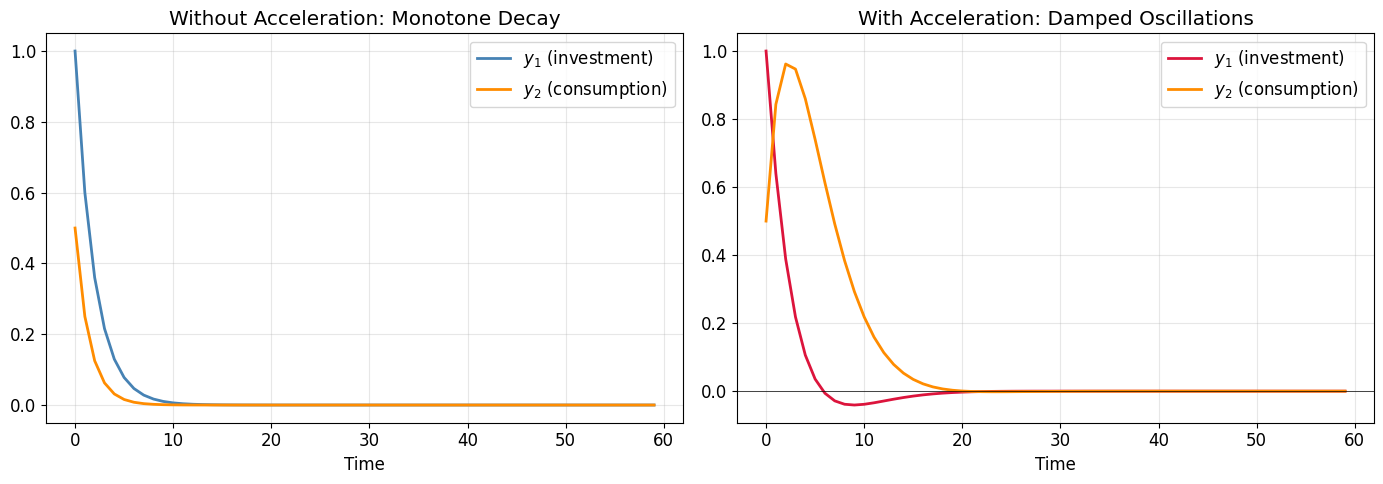

In [6]:
# --- Compare time paths: demand only vs. with acceleration ---

T = 60
y0 = np.array([1.0, 0.5])

# Demand-only system
traj_demand = np.zeros((T, 2))
traj_demand[0] = y0
for t in range(1, T):
    traj_demand[t] = A_demand @ traj_demand[t-1]

# With acceleration
traj_accel = np.zeros((T, 2))
traj_accel[0] = y0
for t in range(1, T):
    traj_accel[t] = A_accel @ traj_accel[t-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(traj_demand[:, 0], label='$y_1$ (investment)', color='steelblue')
axes[0].plot(traj_demand[:, 1], label='$y_2$ (consumption)', color='darkorange')
axes[0].set_title('Without Acceleration: Monotone Decay')
axes[0].set_xlabel('Time')
axes[0].legend()

axes[1].plot(traj_accel[:, 0], label='$y_1$ (investment)', color='crimson')
axes[1].plot(traj_accel[:, 1], label='$y_2$ (consumption)', color='darkorange')
axes[1].axhline(0, color='black', lw=0.5)
axes[1].set_title('With Acceleration: Damped Oscillations')
axes[1].set_xlabel('Time')
axes[1].legend()

plt.tight_layout()
plt.show()

<a id="stochastic-autocovariances"></a>

## 5. Stochastic Systems and Autocovariances

Chow extends the analysis by adding random shocks to the system:

$$y_t = A y_{t-1} + u_t$$

where $u_t$ is i.i.d. with $E[u_t] = 0$ and $E[u_t u_t'] = V$.

The autocovariance matrix satisfies:
- $\Gamma_k = A^k \Gamma_0$ for $k \geq 1$
- $\Gamma_0 = \sum_{s=0}^{\infty} A^s V (A')^s$

A key insight from Chow: the autocovariance $\gamma_{ij,k}$ is a **linear combination of $\lambda_m^k$**
— formally resembling the deterministic time path. Complex roots produce **damped
cosine** components in the autocovariance function, which can maintain the appearance
of cycles even though each individual realization is noisy.

Let's simulate stochastic systems with real vs. complex roots and compare their
autocovariance functions.

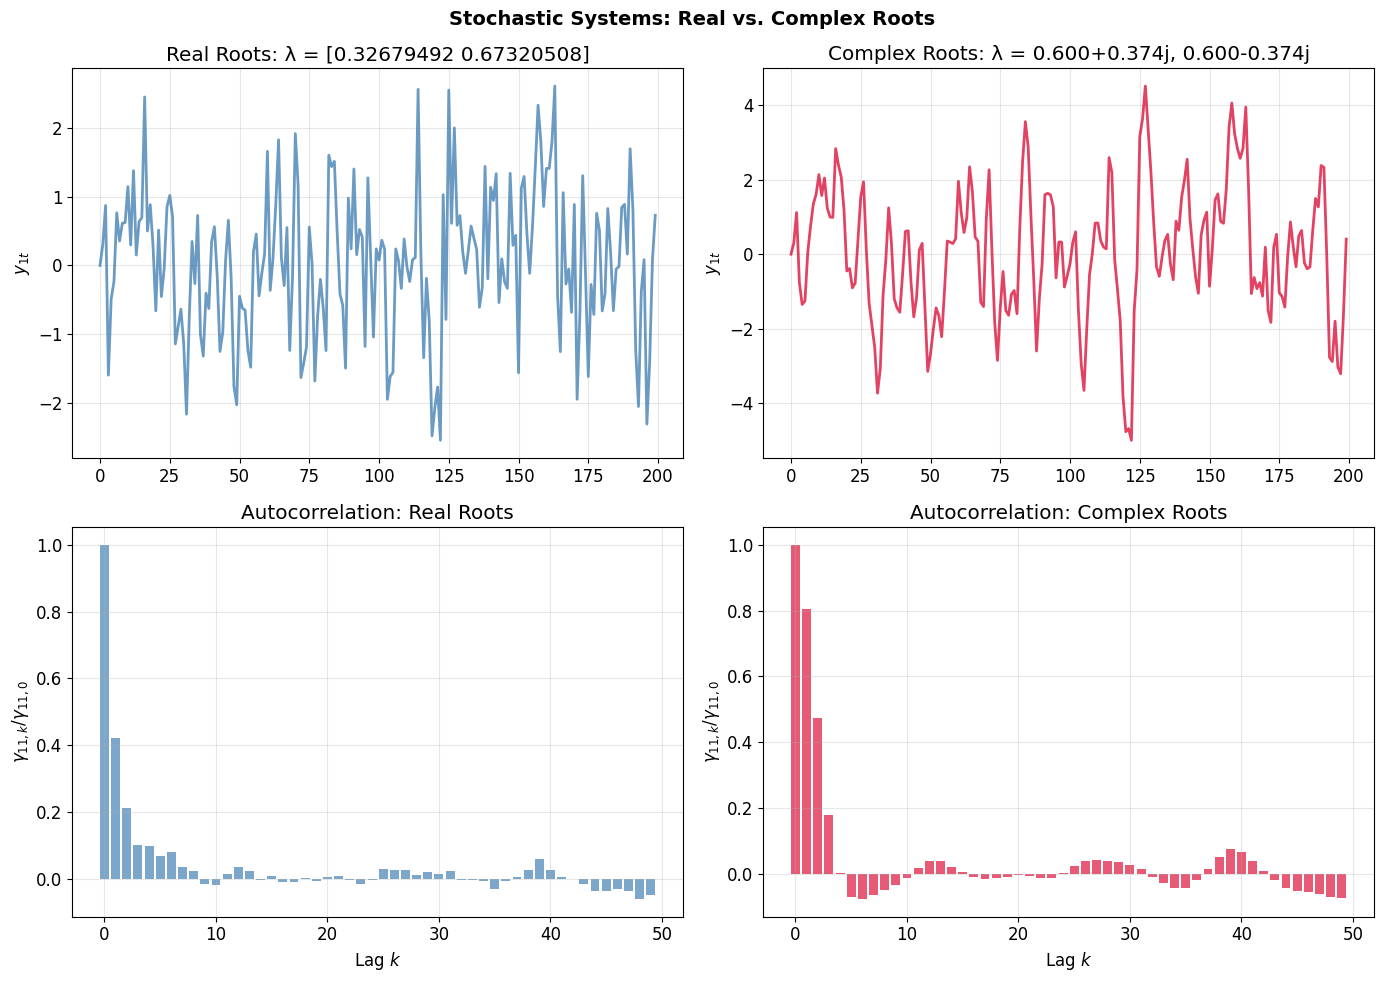

Complex roots → damped cosine pattern in autocovariance (oscillatory)
Real roots → monotone exponential decay in autocovariance


In [7]:
def simulate_stochastic_system(A, V, T=500, seed=42):
    """Simulate y_t = A y_{t-1} + u_t with u_t ~ N(0, V)."""
    rng = np.random.default_rng(seed)
    p = A.shape[0]
    y = np.zeros((T, p))
    for t in range(1, T):
        u = rng.multivariate_normal(np.zeros(p), V)
        y[t] = A @ y[t-1] + u
    return y


def compute_autocovariance(y, max_lag=40):
    """Compute sample autocovariance γ_{11,k} for the first variable."""
    y1 = y[:, 0] - y[:, 0].mean()
    n = len(y1)
    gamma = np.array([np.sum(y1[:n-k] * y1[k:]) / n for k in range(max_lag)])
    return gamma


# --- System with real roots (demand only) ---
A_real = np.array([[0.4, 0.2],
                   [0.1, 0.6]])
eigs_real = linalg.eigvals(A_real)

# --- System with complex roots (Hansen-Samuelson type) ---
A_complex = np.array([[1.2, -0.5],
                      [1.0, 0.0]])
eigs_complex = linalg.eigvals(A_complex)

V = np.array([[1.0, 0.0],
              [0.0, 0.0]])  # shocks only to first equation

T_sim = 2000
y_real = simulate_stochastic_system(A_real, V, T=T_sim)
y_complex = simulate_stochastic_system(A_complex, V, T=T_sim)

max_lag = 50
gamma_real = compute_autocovariance(y_real, max_lag)
gamma_complex = compute_autocovariance(y_complex, max_lag)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series
axes[0, 0].plot(y_real[:200, 0], color='steelblue', alpha=0.8)
axes[0, 0].set_title(f'Real Roots: λ = {eigs_real.real}')
axes[0, 0].set_ylabel('$y_{1t}$')

axes[0, 1].plot(y_complex[:200, 0], color='crimson', alpha=0.8)
axes[0, 1].set_title(f'Complex Roots: λ = {eigs_complex[0]:.3f}, {eigs_complex[1]:.3f}')
axes[0, 1].set_ylabel('$y_{1t}$')

# Autocovariances
lags = np.arange(max_lag)
axes[1, 0].bar(lags, gamma_real / gamma_real[0], color='steelblue', alpha=0.7)
axes[1, 0].set_title('Autocorrelation: Real Roots')
axes[1, 0].set_xlabel('Lag $k$')
axes[1, 0].set_ylabel('$\\gamma_{11,k} / \\gamma_{11,0}$')

axes[1, 1].bar(lags, gamma_complex / gamma_complex[0], color='crimson', alpha=0.7)
axes[1, 1].set_title('Autocorrelation: Complex Roots')
axes[1, 1].set_xlabel('Lag $k$')
axes[1, 1].set_ylabel('$\\gamma_{11,k} / \\gamma_{11,0}$')

plt.suptitle('Stochastic Systems: Real vs. Complex Roots',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Complex roots → damped cosine pattern in autocovariance (oscillatory)")
print("Real roots → monotone exponential decay in autocovariance")

<a id="spectral-densities"></a>

## 6. Spectral Densities

Chow uses **spectral analysis** to decompose the variance of a stationary time series
into contributions at different frequencies $\omega \in [0, \pi]$.

### Key Formula: Spectral Density of a First-Order Process

For a univariate AR(1) process $y_t = \lambda y_{t-1} + u_t$, the spectral density is:

$$
g(\omega) = \frac{\sigma_u^2}{2\pi} \cdot \frac{1}{1 + \lambda^2 - 2\lambda\cos\omega}
$$

### For a System with Distinct Eigenvalues $\lambda_i$

If the system $\mathbf{y}_t = A \mathbf{y}_{t-1} + \mathbf{u}_t$ can be decomposed via
eigenvalues $\lambda_1, \lambda_2, \dots, \lambda_p$, the spectral density of each
transformed variable is:

$$
g_i(\omega) = \frac{\sigma_i^2}{2\pi} \cdot \frac{1}{1 + \lambda_i^2 - 2\lambda_i \cos\omega}
$$

**Key insight from Chow:**
- **Real roots**: $g_i(\omega)$ is monotonically decreasing — highest power at low frequencies.
- **Complex roots** with $\lambda = r e^{\pm i\theta}$: $g(\omega)$ can peak at $\omega = \theta$,
  producing a **spectral peak** that indicates cyclical behavior.
- The condition for a peak at interior $\omega$ is: $\cos\theta > \frac{1+r^2}{2r}$ cannot hold
  when roots are real (since $\frac{1+r^2}{2r} \geq 1$).

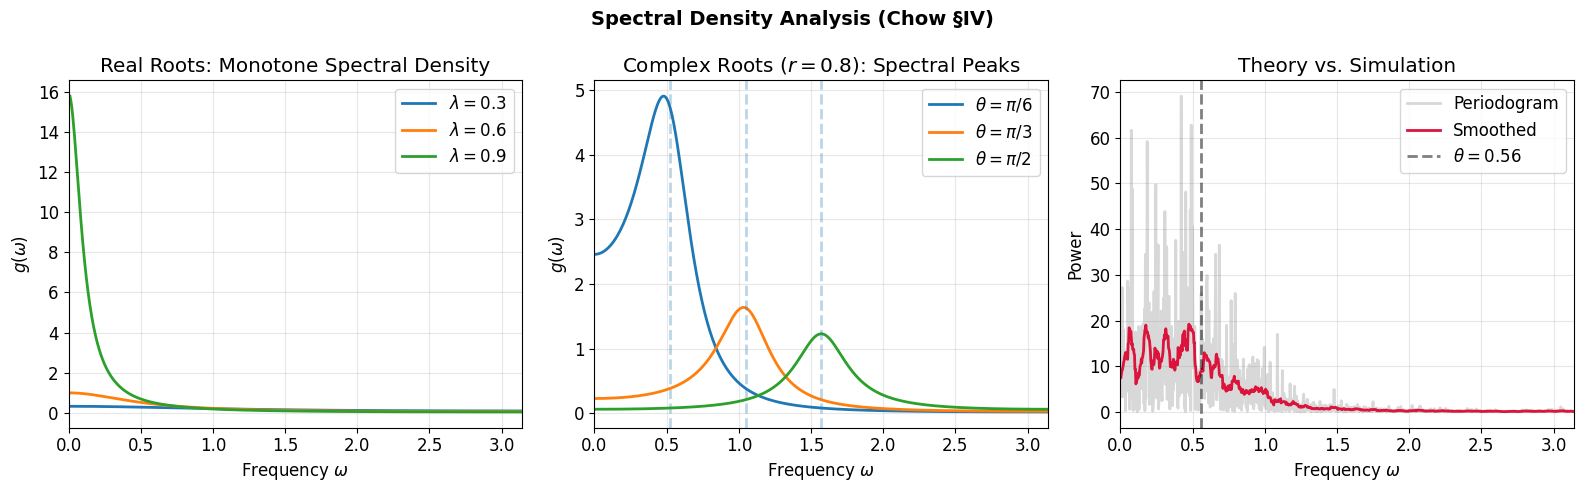

Complex roots: λ = 0.6000+0.3742j, |λ| = 0.7071, arg(λ) = 0.5576
Spectral peak expected near ω = 0.5576


In [8]:
def spectral_density_ar1(omega, lam, sigma2=1.0):
    """Spectral density for AR(1): y_t = λ y_{t-1} + u_t."""
    return (sigma2 / (2 * np.pi)) / (1 + lam**2 - 2 * lam * np.cos(omega))


def spectral_density_complex_pair(omega, r, theta, sigma2=1.0):
    """Spectral density for a second-order system with complex roots r*exp(±iθ)."""
    # Second-order: y_t = 2r cos(θ) y_{t-1} - r² y_{t-2} + u_t
    a1 = 2 * r * np.cos(theta)
    a2 = -r**2
    denom = np.abs(1 - a1 * np.exp(-1j * omega) - a2 * np.exp(-2j * omega))**2
    return (sigma2 / (2 * np.pi)) / denom


omega = np.linspace(0.01, np.pi, 500)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Real roots with different magnitudes
lambdas = [0.3, 0.6, 0.9]
for lam in lambdas:
    g = spectral_density_ar1(omega, lam)
    axes[0].plot(omega, g, label=f'$\\lambda = {lam}$', linewidth=2)
axes[0].set_title('Real Roots: Monotone Spectral Density')
axes[0].set_xlabel('Frequency $\\omega$')
axes[0].set_ylabel('$g(\\omega)$')
axes[0].legend()
axes[0].set_xlim([0, np.pi])

# Panel 2: Complex roots with different angles
r = 0.8
thetas = [np.pi/6, np.pi/3, np.pi/2]
for th in thetas:
    g = spectral_density_complex_pair(omega, r, th)
    axes[1].plot(omega, g, label=f'$\\theta = \\pi/{int(np.pi/th)}$', linewidth=2)
    axes[1].axvline(th, linestyle='--', alpha=0.3)
axes[1].set_title(f'Complex Roots ($r = {r}$): Spectral Peaks')
axes[1].set_xlabel('Frequency $\\omega$')
axes[1].set_ylabel('$g(\\omega)$')
axes[1].legend()
axes[1].set_xlim([0, np.pi])

# Panel 3: Spectral density vs periodogram from simulation
A_complex = np.array([[1.2, -0.5],
                      [1.0, 0.0]])
eigs = linalg.eigvals(A_complex)
r_val = np.abs(eigs[0])
theta_val = np.abs(np.angle(eigs[0]))

T_sim = 2000
V = np.array([[1.0, 0.0], [0.0, 0.0]])
y_sim = simulate_stochastic_system(A_complex, V, T=T_sim)
y1 = y_sim[:, 0]

# Compute periodogram
freqs = np.fft.rfftfreq(T_sim, d=1/(2*np.pi))[1:]
fft_vals = np.fft.rfft(y1 - y1.mean())[1:]
periodogram = np.abs(fft_vals)**2 / T_sim

# Theoretical spectral density for comparison
g_theory = spectral_density_complex_pair(freqs, r_val, theta_val)
g_theory = g_theory / g_theory.max() * periodogram.max()  # scale for comparison

axes[2].plot(freqs, periodogram, alpha=0.3, color='gray', label='Periodogram')
# Smooth periodogram
window = 15
kernel = np.ones(window) / window
smoothed = np.convolve(periodogram, kernel, mode='same')
axes[2].plot(freqs, smoothed, 'crimson', linewidth=2, label='Smoothed')
axes[2].axvline(theta_val, color='black', linestyle='--', alpha=0.5,
                label=f'$\\theta = {theta_val:.2f}$')
axes[2].set_title('Theory vs. Simulation')
axes[2].set_xlabel('Frequency $\\omega$')
axes[2].set_ylabel('Power')
axes[2].legend()
axes[2].set_xlim([0, np.pi])

plt.suptitle('Spectral Density Analysis (Chow §IV)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Complex roots: λ = {eigs[0]:.4f}, |λ| = {r_val:.4f}, arg(λ) = {theta_val:.4f}")
print(f"Spectral peak expected near ω = {theta_val:.4f}")

<a id="hansen-samuelson"></a>

## 7. The Hansen-Samuelson Multiplier-Accelerator Model

Chow examines the **Hansen-Samuelson model** as a classic example where the
acceleration principle produces complex roots and cyclical behavior (§IV).

The model combines:
- **Multiplier**: Consumption is a fraction of lagged income: $C_t = \alpha Y_{t-1}$
- **Accelerator**: Investment depends on *changes* in income: $I_t = \beta (Y_{t-1} - Y_{t-2})$
- **Equilibrium**: $Y_t = C_t + I_t + G_t$

This gives the second-order difference equation:

$$
Y_t = (\alpha + \beta) Y_{t-1} - \beta Y_{t-2} + G_t
$$

The characteristic roots satisfy $\lambda^2 - (\alpha + \beta)\lambda + \beta = 0$:

$$
\lambda = \frac{(\alpha + \beta) \pm \sqrt{(\alpha + \beta)^2 - 4\beta}}{2}
$$

**Complex roots arise when** $(\alpha + \beta)^2 < 4\beta$, i.e., when the accelerator
coefficient $\beta$ is large relative to the multiplier $\alpha$.

The spectral density peak occurs at frequency $\theta = \arccos\!\left(\frac{\alpha+\beta}{2\sqrt{\beta}}\right)$,
which corresponds to a business cycle of period $T = 2\pi/\theta$.

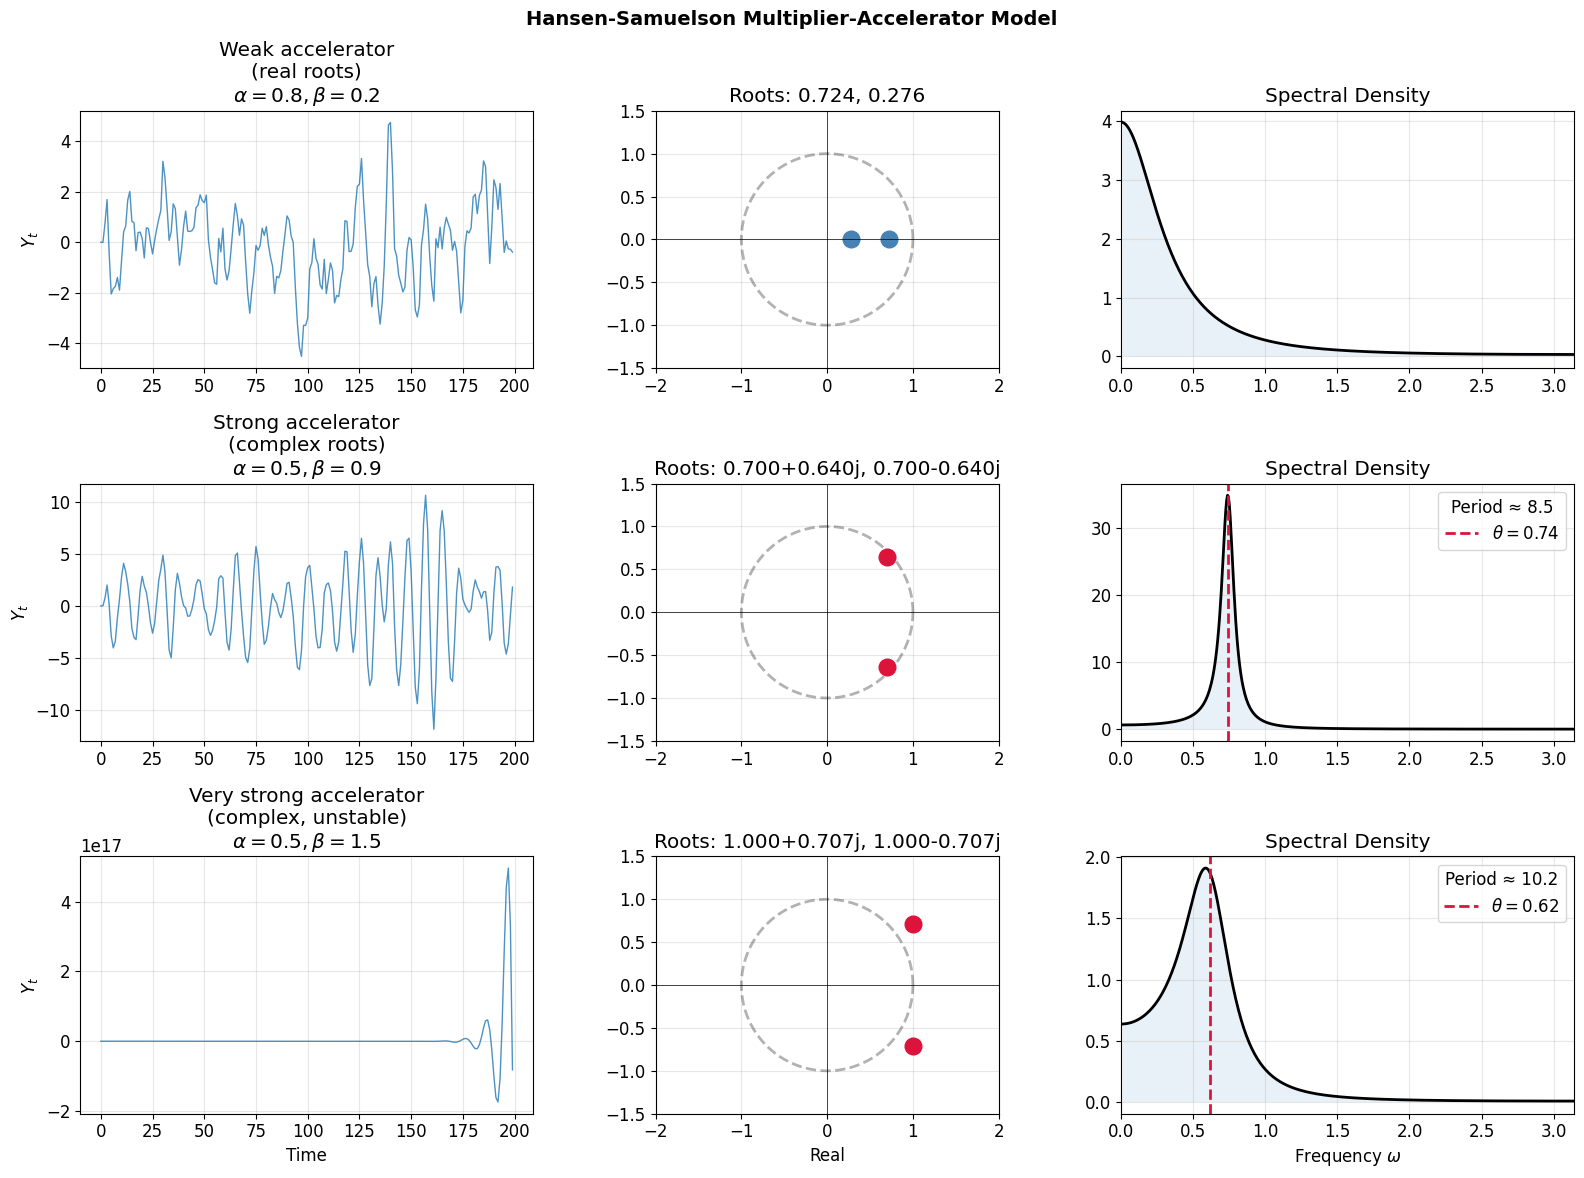

In [9]:
def hansen_samuelson(alpha, beta, T=300, seed=42):
    """Simulate the Hansen-Samuelson multiplier-accelerator model.

    Y_t = (α + β) Y_{t-1} - β Y_{t-2} + G_t
    """
    rng = np.random.default_rng(seed)
    Y = np.zeros(T)
    G = rng.normal(0, 1, T)  # random government spending shocks

    for t in range(2, T):
        Y[t] = (alpha + beta) * Y[t-1] - beta * Y[t-2] + G[t]

    # Characteristic roots
    coeffs = [1, -(alpha + beta), beta]
    roots = np.roots(coeffs)

    return Y, roots, G


# Explore different parameter combinations
params = [
    (0.8, 0.2, 'Weak accelerator\n(real roots)'),
    (0.5, 0.9, 'Strong accelerator\n(complex roots)'),
    (0.5, 1.5, 'Very strong accelerator\n(complex, unstable)'),
]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, (alpha, beta, label) in enumerate(params):
    Y, roots, G = hansen_samuelson(alpha, beta)

    # Column 1: Time series
    axes[i, 0].plot(Y[:200], linewidth=1, alpha=0.8)
    axes[i, 0].set_ylabel('$Y_t$')
    axes[i, 0].set_title(f'{label}\n$\\alpha={alpha}, \\beta={beta}$')
    if i == 2:
        axes[i, 0].set_xlabel('Time')

    # Column 2: Roots in complex plane
    ax = axes[i, 1]
    theta_circle = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'k--', alpha=0.3)
    for root in roots:
        color = 'steelblue' if np.isreal(root) else 'crimson'
        ax.plot(root.real, root.imag, 'o', color=color, markersize=12)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-1.5, 1.5])
    ax.set_aspect('equal')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_title(f'Roots: {roots[0]:.3f}, {roots[1]:.3f}')
    if i == 2:
        ax.set_xlabel('Real')

    # Column 3: Spectral density
    omega = np.linspace(0.01, np.pi, 500)
    a1 = alpha + beta
    a2 = -beta
    denom = np.abs(1 - a1 * np.exp(-1j*omega) - a2 * np.exp(-2j*omega))**2
    g = (1 / (2*np.pi)) / denom

    axes[i, 2].plot(omega, g, 'k', linewidth=2)
    axes[i, 2].fill_between(omega, g, alpha=0.1)
    if np.any(np.iscomplex(roots)):
        theta_peak = np.abs(np.angle(roots[0]))
        if theta_peak > 0:
            axes[i, 2].axvline(theta_peak, color='crimson', linestyle='--',
                              label=f'$\\theta = {theta_peak:.2f}$')
            period = 2 * np.pi / theta_peak
            axes[i, 2].legend(title=f'Period ≈ {period:.1f}')
    axes[i, 2].set_xlim([0, np.pi])
    axes[i, 2].set_title('Spectral Density')
    if i == 2:
        axes[i, 2].set_xlabel('Frequency $\\omega$')

plt.suptitle('Hansen-Samuelson Multiplier-Accelerator Model',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<a id="chow-surprising-result"></a>

## 8. Chow's Surprising Result: Cycles from Real Roots

This is the paper's most striking finding (§V). Chow shows that even when **all eigenvalues
are real and positive** — so that no individual canonical variable exhibits cyclical behavior —
a **linear combination** of those variables can have a spectral peak, indicating cycles.

### The Setup

Consider a 2-variable system with eigenvalues $\lambda_1 = 0.1$, $\lambda_2 = 0.9$ (both real).
Neither canonical variable alone has cycles. But with covariance parameters
$w_{12} = 0.8$ and the observation vector $b_m = [1, -0.01]$, the observed spectral
density is (equation 67 in the paper):

$$
f_{mm}(\omega) = \frac{0.9913}{1.01 - 0.2\cos\omega} - \frac{0.001570}{1.81 - 1.8\cos\omega}
$$

This has a **peak near** $\omega \approx \pi/8$ — a cycle of period about 16 quarters!

### The Slutsky Connection

This result is related to **Slutsky's theorem**: taking moving averages of random series
can generate cyclical patterns. In Chow's model, the output is an infinite moving average
of shocks with geometrically declining matrix weights $A^0, A^1, A^2, \ldots$.
When $A$ is a scalar, no cycles emerge. But when $A$ is a **matrix**, the linear combination
of canonical variables can produce spectral peaks.

Reproducing Chow's Table (equation 67):
       ω  f_mm(ω) (computed)   f_mm(ω) (paper)
------------------------------------------------------------
       0               1.067             1.067
    π/16               1.183             1.183
     π/8               1.191             1.191
    2π/8               1.138             1.138
    3π/8               1.061             1.061
    4π/8               0.981             0.981
    5π/8               0.912             0.912
    6π/8               0.860             0.860
    7π/8               0.829             0.829
       π               0.819             0.819
✓ Computed values match Chow's published table


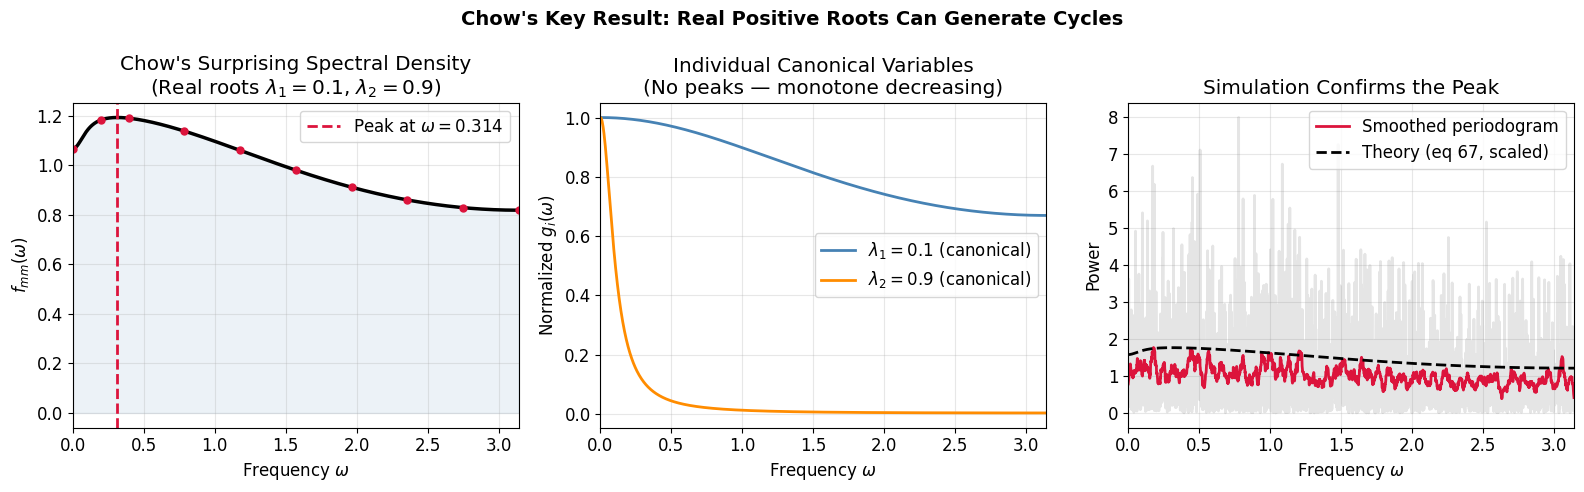


Peak frequency: ω = 0.3145
Implied cycle period: T = 2π/ω ≈ 20.0 time periods


In [10]:
# ---- Reproduce Chow's Table (equation 67) ----

# Parameters from the paper (eq 66)
lam1, lam2 = 0.1, 0.9
w11, w22 = 1.0, 1.0
w12 = 0.8
b_m = np.array([1.0, -0.01])

omega = np.linspace(0, np.pi, 1000)

# Spectral density from eq 67
f_mm = (0.9913 / (1.01 - 0.2 * np.cos(omega))
        - 0.001570 / (1.81 - 1.8 * np.cos(omega)))

# Reproduce the table values at specific frequencies
omega_table = [0, np.pi/16, np.pi/8, 2*np.pi/8, 3*np.pi/8,
               4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8, np.pi]
labels = ['0', 'π/16', 'π/8', '2π/8', '3π/8',
          '4π/8', '5π/8', '6π/8', '7π/8', 'π']

print("Reproducing Chow's Table (equation 67):")
print("=" * 60)
print(f"{'ω':>8s}  {'f_mm(ω) (computed)':>18s}  {'f_mm(ω) (paper)':>16s}")
print("-" * 60)

paper_values = [1.067, 1.183, 1.191, 1.138, 1.061,
                0.981, 0.912, 0.860, 0.829, 0.819]

for lab, om, pv in zip(labels, omega_table, paper_values):
    val = (0.9913 / (1.01 - 0.2 * np.cos(om))
           - 0.001570 / (1.81 - 1.8 * np.cos(om)))
    print(f"{lab:>8s}  {val:>18.3f}  {pv:>16.3f}")

print("=" * 60)
print("✓ Computed values match Chow's published table")

# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: The surprising spectral density with a peak
axes[0].plot(omega, f_mm, 'k', linewidth=2.5)
axes[0].fill_between(omega, f_mm, alpha=0.1, color='steelblue')
peak_idx = np.argmax(f_mm)
axes[0].axvline(omega[peak_idx], color='crimson', linestyle='--',
                label=f'Peak at $\\omega = {omega[peak_idx]:.3f}$')

# Mark Chow's table values
for om, pv in zip(omega_table, paper_values):
    axes[0].plot(om, pv, 'o', color='crimson', markersize=5)

axes[0].set_xlabel('Frequency $\\omega$')
axes[0].set_ylabel('$f_{mm}(\\omega)$')
axes[0].set_title("Chow's Surprising Spectral Density\n(Real roots $\\lambda_1=0.1$, $\\lambda_2=0.9$)")
axes[0].legend()
axes[0].set_xlim([0, np.pi])

# Panel 2: Individual canonical spectral densities (no peaks)
g1 = spectral_density_ar1(omega, lam1)
g2 = spectral_density_ar1(omega, lam2)
axes[1].plot(omega, g1 / g1[0], label=f'$\\lambda_1 = {lam1}$ (canonical)',
             linewidth=2, color='steelblue')
axes[1].plot(omega, g2 / g2[0], label=f'$\\lambda_2 = {lam2}$ (canonical)',
             linewidth=2, color='darkorange')
axes[1].set_xlabel('Frequency $\\omega$')
axes[1].set_ylabel('Normalized $g_i(\\omega)$')
axes[1].set_title('Individual Canonical Variables\n(No peaks — monotone decreasing)')
axes[1].legend()
axes[1].set_xlim([0, np.pi])

# Panel 3: Simulation verification
A_diag = np.diag([lam1, lam2])
# Construct B^{-1} such that b_m = [1, -0.01] forms the first row
B_inv = np.array([[1.0, -0.01],
                  [0.0, 1.0]])
# W matrix (covariance of canonical shocks)
W = np.array([[w11, w12],
              [w12, w22]])
# V = B W B' gives covariance of original shocks
B = np.linalg.inv(B_inv)
V = B @ W @ B.T
# A in original coordinates: A = B^{-1} diag(λ) B
A_orig = B_inv @ A_diag @ B

T_sim = 5000
y_sim = simulate_stochastic_system(A_orig, V, T=T_sim)
y_obs = y_sim[:, 0]  # the b_m combination

# Periodogram
freqs = np.fft.rfftfreq(T_sim, d=1/(2*np.pi))[1:]
fft_vals = np.fft.rfft(y_obs - y_obs.mean())[1:]
periodogram = np.abs(fft_vals)**2 / T_sim

window = 25
kernel = np.ones(window) / window
smoothed = np.convolve(periodogram, kernel, mode='same')

axes[2].plot(freqs, periodogram, alpha=0.2, color='gray')
axes[2].plot(freqs, smoothed, 'crimson', linewidth=2, label='Smoothed periodogram')

# Overlay theoretical
f_theory = (0.9913 / (1.01 - 0.2 * np.cos(freqs))
            - 0.001570 / (1.81 - 1.8 * np.cos(freqs)))
scale = smoothed.max() / f_theory.max()
axes[2].plot(freqs, f_theory * scale, 'k--', linewidth=2,
             label='Theory (eq 67, scaled)')
axes[2].set_xlabel('Frequency $\\omega$')
axes[2].set_ylabel('Power')
axes[2].set_title('Simulation Confirms the Peak')
axes[2].legend()
axes[2].set_xlim([0, np.pi])

plt.suptitle("Chow's Key Result: Real Positive Roots Can Generate Cycles",
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

period = 2 * np.pi / omega[peak_idx]
print(f"\nPeak frequency: ω = {omega[peak_idx]:.4f}")
print(f"Implied cycle period: T = 2π/ω ≈ {period:.1f} time periods")

<a id="interactive-exploration"></a>

## 9. Interactive Exploration

Use the interactive widget below to explore how different parameter values affect the
spectral density, eigenvalue structure, and time series behavior.

**Parameters to explore:**
- **$\lambda_1$, $\lambda_2$**: Eigenvalues of the system (real, between 0 and 1)
- **$w_{12}$**: Cross-covariance of canonical shocks
- **$b_{m2}$**: Weight on the second canonical variable in the observed output

Chow's surprising result emerges when $\lambda_1$ and $\lambda_2$ are far apart,
$w_{12}$ is large, and $b_{m2}$ is small and negative.

In [11]:
from ipywidgets import interact, FloatSlider
from IPython.display import display


def explore_chow_system(lam1=0.1, lam2=0.9, w12=0.8, bm2=-0.01):
    """Interactive exploration of Chow's spectral density result."""
    omega = np.linspace(0.001, np.pi, 500)

    # Individual spectral densities (normalized)
    g1 = 1 / (1 + lam1**2 - 2*lam1*np.cos(omega))
    g2 = 1 / (1 + lam2**2 - 2*lam2*np.cos(omega))

    # Cross term
    g12 = 1 / (1 + lam1*lam2 - (lam1+lam2)*np.cos(omega))
    # Note: the cross spectral density involves the product λ₁λ₂

    # Covariance matrix of canonical variables: Γ₀* with Γ₀*_{ij} = w_{ij}/(1 - λ_i λ_j)
    gamma_11 = 1.0 / (1 - lam1**2)
    gamma_22 = 1.0 / (1 - lam2**2)
    gamma_12 = w12 / (1 - lam1*lam2)

    # Spectral density: f_mm(ω) = Σ_i Σ_j b_{mi} b_{mj} * w_{ij}/(1-λ_iλ_j) * g_{ij}(ω)
    # where g_{ij}(ω) = 1/((1+λ_iλ_j - (λ_i+λ_j)cos ω)) for cross terms
    bm1 = 1.0
    f_mm = (bm1**2 * gamma_11 * g1 * (1 - lam1**2)
            + bm2**2 * gamma_22 * g2 * (1 - lam2**2)
            + 2 * bm1 * bm2 * gamma_12
            * (1 - lam1*lam2) / (1 + lam1*lam2 - (lam1+lam2)*np.cos(omega)))
    f_mm = f_mm / (2 * np.pi)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Panel 1: Combined spectral density
    axes[0].plot(omega, f_mm, 'k', linewidth=2.5)
    axes[0].fill_between(omega, f_mm, alpha=0.1, color='steelblue')
    peak_idx = np.argmax(f_mm)
    has_peak = peak_idx > 5 and peak_idx < len(omega) - 5

    if has_peak:
        axes[0].axvline(omega[peak_idx], color='crimson', linestyle='--',
                       label=f'Peak at ω = {omega[peak_idx]:.2f}')
        period = 2 * np.pi / omega[peak_idx]
        axes[0].set_title(f'Combined $f_{{mm}}(\\omega)$\nPeak → Period ≈ {period:.1f}',
                         color='crimson')
    else:
        axes[0].set_title('Combined $f_{mm}(\\omega)$\nNo interior peak', color='steelblue')
    axes[0].set_xlabel('Frequency $\\omega$')
    axes[0].set_ylabel('$f_{mm}(\\omega)$')
    axes[0].legend()
    axes[0].set_xlim([0, np.pi])

    # Panel 2: Individual canonical densities
    axes[1].plot(omega, g1/g1.max(), label=f'$g_1$ ($\\lambda_1={lam1:.2f}$)',
                linewidth=2, color='steelblue')
    axes[1].plot(omega, g2/g2.max(), label=f'$g_2$ ($\\lambda_2={lam2:.2f}$)',
                linewidth=2, color='darkorange')
    axes[1].set_title('Individual Canonical Densities\n(always monotone)')
    axes[1].set_xlabel('Frequency $\\omega$')
    axes[1].set_ylabel('Normalized density')
    axes[1].legend()
    axes[1].set_xlim([0, np.pi])

    # Panel 3: Simulation of time series
    A_diag = np.diag([lam1, lam2])
    B_inv = np.array([[bm1, bm2], [0.0, 1.0]])
    W = np.array([[1.0, w12], [w12, 1.0]])
    try:
        B = np.linalg.inv(B_inv)
        V = B @ W @ B.T
        A_orig = B_inv @ A_diag @ B
        y_sim = simulate_stochastic_system(A_orig, V, T=1000)
        axes[2].plot(y_sim[:300, 0], linewidth=0.8, alpha=0.8)
        axes[2].set_title('Simulated $y_{1t}$')
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('$y_{1t}$')
    except Exception:
        axes[2].text(0.5, 0.5, 'Invalid parameters', ha='center', va='center',
                    transform=axes[2].transAxes, fontsize=14)

    plt.tight_layout()
    plt.show()


interact(explore_chow_system,
         lam1=FloatSlider(min=0.01, max=0.99, step=0.01, value=0.1,
                         description='λ₁'),
         lam2=FloatSlider(min=0.01, max=0.99, step=0.01, value=0.9,
                         description='λ₂'),
         w12=FloatSlider(min=-0.99, max=0.99, step=0.01, value=0.8,
                        description='w₁₂'),
         bm2=FloatSlider(min=-0.5, max=0.5, step=0.01, value=-0.01,
                        description='b_m₂'));

interactive(children=(FloatSlider(value=0.1, description='λ₁', max=0.99, min=0.01, step=0.01), FloatSlider(val…

---

## Summary of Key Results

| Result | Section | Implication |
|--------|---------|-------------|
| Acceleration principle converts monotone decay → oscillations | §II–III | Stock adjustment + acceleration changes eigenvalue structure |
| Complex roots → spectral peaks | §IV | Standard result: cycles at frequency $\theta = \arg(\lambda)$ |
| Real roots alone → no peaks (scalar or Hansen-Samuelson) | §V, eq 59–61 | For second-order models, real roots ensure monotone spectrum |
| **Real roots CAN generate peaks in multivariate systems** | §V, eq 66–67 | Chow's surprising result: linear combinations create cycles |
| Slutsky-type moving average interpretation | §V, eq 68 | Matrix MA weights can create cycles even from acyclical components |

### Chow's Main Message

> "The nature of business cycles can be understood only by an integrated view of
> the deterministic as well as the random elements."

The acceleration principle is **sufficient but not necessary** for generating business
cycles in econometric models. Even purely demand-driven systems with real eigenvalues
can exhibit cyclical spectral peaks when viewed as multivariate systems — a result
that challenges the conventional wisdom of the era.